In [33]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}


In [34]:
gwas = pd.read_csv('gwas_catalog_v1.0.2-associations_e113_r2025-03-08.tsv', sep='\t')

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_2552/4109629132.py:1: DtypeWarning: Columns (9,11,12,13,23,29) have mixed types. Specify dtype option on import or set low_memory=False.
  gwas = pd.read_csv('gwas_catalog_v1.0.2-associations_e113_r2025-03-08.tsv', sep='\t')


In [35]:
# Clean up MAPPED_GENE column
gwas['MAPPED_GENE'] = gwas['MAPPED_GENE'].str.split(',').str[0]
gwas['MAPPED_GENE'] = gwas['MAPPED_GENE'].str.split('-').str[0]

In [36]:
gwas[['REPORTED GENE(S)', 'MAPPED_GENE', 'UPSTREAM_GENE_ID',
       'DOWNSTREAM_GENE_ID',]]

,REPORTED GENE(S),MAPPED_GENE,UPSTREAM_GENE_ID,DOWNSTREAM_GENE_ID
0,"SEPT5, GP1BB",GP1BB,NaN,NaN
1,ARVCF,ARVCF,NaN,NaN
2,MN1,MN1,NaN,NaN
3,EWSR1,EWSR1,NaN,NaN
4,TMPRSS6,NaN,NaN,NaN
...,...,...,...,...
788647,NaN,FADS2,NaN,NaN
788648,NaN,FADS2,NaN,NaN
788649,NaN,FADS2,NaN,NaN
788650,NaN,FADS2,NaN,NaN


In [37]:
# Select genes based on patways modeled in the minimal - whole body model
# https://www.gsea-msigdb.org/gsea/msigdb/human/genesets.jsp?collection=CP:REACTOME

gene_sets_pathways = pd.read_csv('gene_sets_curated.csv')

In [38]:
gene_sets_pathways

,gene_name,pathway,use,comment
0,ABCD1,Fatty acid oxidation,True,NaN
1,ACAA1,Fatty acid oxidation,True,NaN
2,ACOT4,Fatty acid oxidation,True,NaN
3,ACOT6,Fatty acid oxidation,True,NaN
4,ACOT8,Fatty acid oxidation,True,NaN
...,...,...,...,...
210,PPP1CB,Triglyceride catabolism,True,NaN
211,PPP1CC,Triglyceride catabolism,True,NaN
212,PRKACA,Triglyceride catabolism,True,NaN
213,PRKACB,Triglyceride catabolism,True,NaN


In [39]:
# Map the GWAS catalog to the model
gwas_mapped = pd.merge(gwas, gene_sets_pathways, left_on='MAPPED_GENE', right_on='gene_name', how='left')
gwas_mapped = gwas_mapped[gwas_mapped['gene_name'].notnull()]

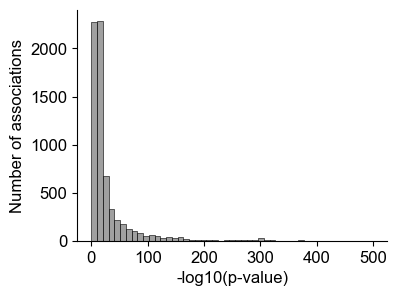

In [40]:
# Plot p-value distribution
f, ax = plt.subplots(figsize=(4, 3))
sns.histplot(gwas_mapped['PVALUE_MLOG'], bins=np.linspace(0, 500, 50), color='grey')

ax.set_xlabel('-log10(p-value)')
ax.set_ylabel('Number of associations')
sns.despine()


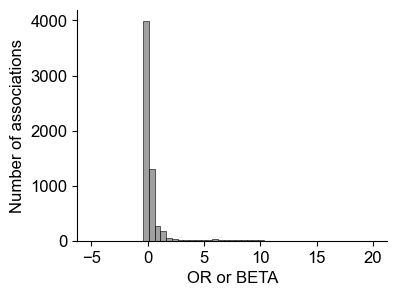

In [41]:
# Histogram of traits asooicated with reactions in the model
f, ax = plt.subplots(figsize=(4, 3))
sns.histplot(gwas_mapped['OR or BETA'], color='grey', bins=np.linspace(-5, 20, 50))
ax.set_ylabel('Number of associations')
ax.set_xlabel('OR or BETA')
sns.despine()

In [42]:
# Write the list of mapped traits into a file
gwas_mapped.to_csv('gwas_mapped.csv')

In [43]:
# Make pivot table of the mapped traits and the reactions
column = 'DISEASE/TRAIT'
gwas_mapped_pivot = gwas_mapped.pivot_table(index='gene_name', columns=column, values='OR or BETA')

Text(0, 0.5, 'Number of traits')

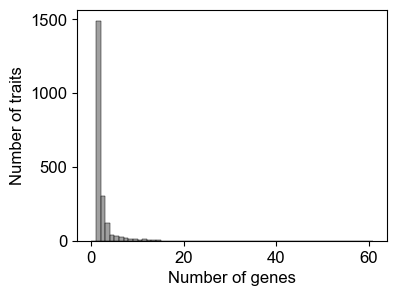

In [44]:
gwas_mapped_pivot.shape

num_genes_per_trait =gwas_mapped_pivot.shape[0] - gwas_mapped_pivot.isna().sum(axis=0).sort_values(ascending=True)

max_counts = num_genes_per_trait.max()

f, ax = plt.subplots(figsize=(4, 3))

sns.histplot(num_genes_per_trait, bins=np.linspace(0, max_counts, max_counts+1), color='grey')

ax.set_xlabel('Number of genes')
ax.set_ylabel('Number of traits')

In [45]:
trait_list = [ t for t in gwas_mapped['DISEASE/TRAIT'].unique()] # if 'diabetes' in str(t).lower() ]
# Write into a file
with open('trait_list.txt', 'w') as f:
    for item in trait_list:
        f.write("%s\n" % item)

In [15]:
hue_order = gwas_mapped.pathway.unique()    

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_2552/1572574020.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_mapped_selected['pathway'] = pd.Categorical(gwas_mapped_selected['pathway'], categories=hue_order, ordered=True)


('The trans-ancestral genomic architecture of glycemic traits.', 34059833, '2021-05-31', 'Chen J', 'Nat Genet')


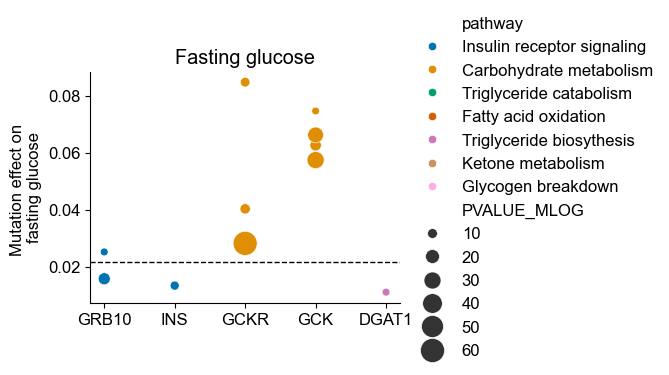

In [16]:
# Make plot for the main text 
trait = 'Fasting glucose'
glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()

# hue_order = ['Insulin receptor signaling', 
#              'Carbohydrate metabolism',
#              'Glycogen breakdown',
#              'Fatty acid oxidation',
#              'Ketone metabolism',
#              'Triglyceride catabolism', 
#              'Triglyceride biosythesis',]
           

selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['DISEASE/TRAIT'] == trait)
gwas_mapped_selected = gwas_mapped[selected_genes]

# Count the number of genes per study
num_genes_per_study = gwas_mapped_selected.groupby(['STUDY','PUBMEDID','DATE','FIRST AUTHOR','JOURNAL']).size()

# Select only a single study 
selected_study = num_genes_per_study.idxmax()


selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['DISEASE/TRAIT'] == trait) & (gwas_mapped['STUDY'] == selected_study[0])
gwas_mapped_selected = gwas_mapped[selected_genes]

# Sort using the pathways preservin the order in the hue_order
gwas_mapped_selected['pathway'] = pd.Categorical(gwas_mapped_selected['pathway'], categories=hue_order, ordered=True)
gwas_mapped_selected = gwas_mapped_selected.sort_values('pathway')

# Scale the effect size by the explained total effect nature gen paper here
# total_effect_fasted_glucose = 4.3 * 18 # mg/dL
# gwas_mapped_selected['OR or BETA'] = gwas_mapped_selected['OR or BETA'] * total_effect_fasted_glucose

f, ax = plt.subplots(figsize=(4, 3))
sns.scatterplot(data=gwas_mapped_selected, x='gene_name', y='OR or BETA', hue='pathway', palette='colorblind',
                size='PVALUE_MLOG', ax=ax, sizes=(0,300), size_norm=(0, 60),)


# Add a horizontal line at the median of the effect size of this study
gwas_selected = gwas[(gwas['PUBMEDID'] == selected_study[1]) & (gwas['DISEASE/TRAIT'] == trait)]

median_effect_size = gwas_selected['OR or BETA'].median()
plt.axhline(median_effect_size, color='black', linestyle='--', linewidth=1)


#plt.ylim(0,0.1)

ax.set_ylabel('Mutation effect on \n' + trait.lower())
ax.set_xlabel('')

# put the legend out of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
sns.despine()

# Add title from the fist authors and the year of the study
title = trait  #+'\n' + selected_study[3] + '. '+ str(selected_study[4])  +' (' + str(pd.to_datetime(selected_study[2]).year) + ')'
plt.title(title)


print(selected_study)

plt.savefig('./../output/gwas_glucose_fasting.svg', bbox_inches='tight')

In [17]:
gwas_mapped_selected

,DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,...,PLATFORM [SNPS PASSING QC],CNV,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,GENOTYPING TECHNOLOGY,gene_name,pathway,use,comment
162946,2021-06-10,34059833,Chen J,2021-05-31,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/34059833,The trans-ancestral genomic architecture of gl...,Fasting glucose,"200,622 European ancestry individuals",NaN,...,"Affymetrix, Illumina [34064007] (imputed)",N,glucose measurement,http://www.ebi.ac.uk/efo/EFO_0004468,GCST90002232,"Genome-wide genotyping array, Targeted genotyp...",GRB10,Insulin receptor signaling,True,NaN
163193,2021-06-10,34059833,Chen J,2021-05-31,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/34059833,The trans-ancestral genomic architecture of gl...,Fasting glucose,"19,247 Hispanic individuals",NaN,...,"Affymetrix, Illumina [28177426] (imputed)",N,glucose measurement,http://www.ebi.ac.uk/efo/EFO_0004468,GCST90002233,"Genome-wide genotyping array, Targeted genotyp...",GRB10,Insulin receptor signaling,True,NaN
163221,2021-06-10,34059833,Chen J,2021-05-31,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/34059833,The trans-ancestral genomic architecture of gl...,Fasting glucose,"200,622 European ancestry individuals",NaN,...,"Affymetrix, Illumina [34064007] (imputed)",N,glucose measurement,http://www.ebi.ac.uk/efo/EFO_0004468,GCST90002232,"Genome-wide genotyping array, Targeted genotyp...",INS,Insulin receptor signaling,True,NaN
162968,2021-06-10,34059833,Chen J,2021-05-31,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/34059833,The trans-ancestral genomic architecture of gl...,Fasting glucose,"35,619 East Asian ancestry individuals",NaN,...,"Affymetrix, Illumina [15438438] (imputed)",N,glucose measurement,http://www.ebi.ac.uk/efo/EFO_0004468,GCST90002231,"Genome-wide genotyping array, Targeted genotyp...",GCKR,Carbohydrate metabolism,True,NaN
162974,2021-06-10,34059833,Chen J,2021-05-31,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/34059833,The trans-ancestral genomic architecture of gl...,Fasting glucose,"35,619 East Asian ancestry individuals",NaN,...,"Affymetrix, Illumina [15438438] (imputed)",N,glucose measurement,http://www.ebi.ac.uk/efo/EFO_0004468,GCST90002231,"Genome-wide genotyping array, Targeted genotyp...",GCK,Carbohydrate metabolism,True,NaN
163009,2021-06-10,34059833,Chen J,2021-05-31,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/34059833,The trans-ancestral genomic architecture of gl...,Fasting glucose,"16,579 African American individuals",NaN,...,"Affymetrix, Illumina [27843817] (imputed)",N,glucose measurement,http://www.ebi.ac.uk/efo/EFO_0004468,GCST90002230,"Genome-wide genotyping array, Targeted genotyp...",GCK,Carbohydrate metabolism,True,NaN
163028,2021-06-10,34059833,Chen J,2021-05-31,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/34059833,The trans-ancestral genomic architecture of gl...,Fasting glucose,"200,622 European ancestry individuals",NaN,...,"Affymetrix, Illumina [34064007] (imputed)",N,glucose measurement,http://www.ebi.ac.uk/efo/EFO_0004468,GCST90002232,"Genome-wide genotyping array, Targeted genotyp...",GCKR,Carbohydrate metabolism,True,NaN
163149,2021-06-10,34059833,Chen J,2021-05-31,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/34059833,The trans-ancestral genomic architecture of gl...,Fasting glucose,"9,343 South Asian ancestry individuals",NaN,...,"Illumina, Perlegen [20274841] (imputed)",N,glucose measurement,http://www.ebi.ac.uk/efo/EFO_0004468,GCST90002234,Genome-wide genotyping array,GCKR,Carbohydrate metabolism,True,NaN
163155,2021-06-10,34059833,Chen J,2021-05-31,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/34059833,The trans-ancestral genomic architecture of gl...,Fasting glucose,"9,343 South Asian ancestry individuals",NaN,...,"Illumina, Perlegen [20274841] (imputed)",N,glucose measurement,http://www.ebi.ac.uk/efo/EFO_0004468,GCST90002234,Genome-wide genotyping array,GCK,Carbohydrate metabolism,True,NaN
163186,2021-06-10,34059833,Chen J,2021-05-31,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/

<Axes: xlabel='OR or BETA', ylabel='Count'>

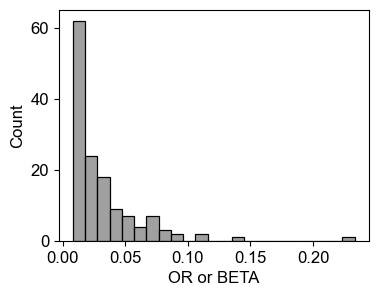

In [18]:
# Histo gram of all beta values in this study
f, ax = plt.subplots(figsize=(4, 3))
sns.histplot(gwas_selected['OR or BETA'], color='grey')

In [19]:
gwas_selected['OR or BETA'].describe()

count    140.000000
mean       0.031470
std        0.029792
min        0.008200
25%        0.012500
50%        0.021800
75%        0.038475
max        0.233300
Name: OR or BETA, dtype: float64

('The trans-ancestral genomic architecture of glycemic traits.', 34059833, '2021-05-31', 'Chen J', 'Nat Genet')


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_2552/4195785278.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_mapped_selected['pathway'] = pd.Categorical(gwas_mapped_selected['pathway'], categories=hue_order, ordered=True)


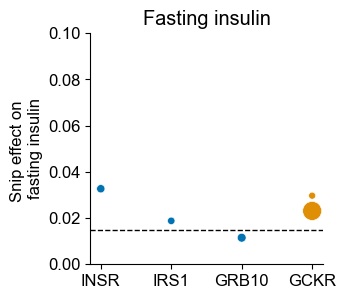

In [20]:
# Make plot for the main text 

trait = 'Fasting insulin'

glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()
           

selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['DISEASE/TRAIT'] == trait)
gwas_mapped_selected = gwas_mapped[selected_genes]

# Count the number of genes per study
num_genes_per_study = gwas_mapped_selected.groupby(['STUDY','PUBMEDID','DATE','FIRST AUTHOR','JOURNAL']).size()

# Select only a single study 
selected_study = num_genes_per_study.idxmax()


selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['DISEASE/TRAIT'] == trait) & (gwas_mapped['STUDY'] == selected_study[0])
gwas_mapped_selected = gwas_mapped[selected_genes]

# Sort using the pathways preservin the order in the hue_order
gwas_mapped_selected['pathway'] = pd.Categorical(gwas_mapped_selected['pathway'], categories=hue_order, ordered=True)
gwas_mapped_selected = gwas_mapped_selected.sort_values('pathway')


f, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(data=gwas_mapped_selected, x='gene_name', y='OR or BETA', hue='pathway', hue_order=hue_order, palette='colorblind',
                size='PVALUE_MLOG', ax=ax, sizes=(0,300), size_norm=(0, 60),legend=False)

plt.ylim(0,0.1)


# Add a horizontal line at the median of the effect size of this study
gwas_selected = gwas[(gwas['PUBMEDID'] == selected_study[1]) & (gwas['DISEASE/TRAIT'] == trait)]

median_effect_size = gwas_selected['OR or BETA'].median()
plt.axhline(median_effect_size, color='black', linestyle='--', linewidth=1)


ax.set_ylabel('Snip effect on \n' + trait.lower())
ax.set_xlabel('')

# put the legend out of the plot
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
sns.despine()

# Add title from the fist authors and the year of the study
title = trait #+'\n' + selected_study[3] + '. '+ str(selected_study[4])  +' (' + str(pd.to_datetime(selected_study[2]).year) + ')'
plt.title(title)

print(selected_study)


plt.savefig('./../output/gwas_insulin_fasting.svg', bbox_inches='tight')

In [21]:
gwas_selected['OR or BETA'].describe()

count    65.000000
mean      0.024698
std       0.039990
min       0.008600
25%       0.011600
50%       0.014700
75%       0.025000
max       0.327000
Name: OR or BETA, dtype: float64

In [22]:
gwas_selected['OR or BETA'].describe()

count    65.000000
mean      0.024698
std       0.039990
min       0.008600
25%       0.011600
50%       0.014700
75%       0.025000
max       0.327000
Name: OR or BETA, dtype: float64

In [23]:
# effectzies in this sty

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_2552/1064895171.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_mapped_selected['pathway'] = pd.Categorical(gwas_mapped_selected['pathway'], categories=hue_order, ordered=True)


('Diversity and scale: Genetic architecture of 2068 traits in the VA Million Veteran Program.', 39024449, '2024-07-19', 'Verma A', 'Science')


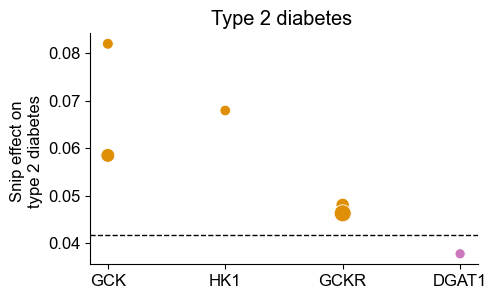

In [24]:
# Make plot for the main text 

#trait = 'Takes medication for Diabetes/sugar?'
trait = 'Diabetes / "Sugar"'
#trait = 'Medication use for T2D (number of purchases)'
#trait = 'Fasting insulin adjusted for BMI'
trait = 'Type 2 diabetes (PheCode 250.2)'

glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()


selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['DISEASE/TRAIT'] == trait)
gwas_mapped_selected = gwas_mapped[selected_genes]

# Count the number of genes per study
num_genes_per_study = gwas_mapped_selected.groupby(['STUDY','PUBMEDID','DATE','FIRST AUTHOR','JOURNAL']).size()

# Select only a single study 
selected_study = num_genes_per_study.idxmax()


selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['DISEASE/TRAIT'] == trait) & (gwas_mapped['STUDY'] == selected_study[0])
gwas_mapped_selected = gwas_mapped[selected_genes]

# Sort using the pathways preservin the order in the hue_order
gwas_mapped_selected['pathway'] = pd.Categorical(gwas_mapped_selected['pathway'], categories=hue_order, ordered=True)
gwas_mapped_selected = gwas_mapped_selected.sort_values('pathway')



f, ax = plt.subplots(figsize=(5, 3))
sns.scatterplot(data=gwas_mapped_selected, x='gene_name', y='OR or BETA', hue='pathway', hue_order=hue_order, palette='colorblind',
                size='PVALUE_MLOG', ax=ax, sizes=(0,300), size_norm=(0, 60),legend=False)

#plt.ylim(0,0.1)


# Add a horizontal line at the median of the effect size of this study
gwas_selected = gwas[(gwas['PUBMEDID'] == selected_study[1]) & (gwas['DISEASE/TRAIT'] == trait)]

median_effect_size = gwas_selected['OR or BETA'].median()
plt.axhline(median_effect_size, color='black', linestyle='--', linewidth=1)

ax.set_ylabel('Snip effect on \n' + trait.replace('(PheCode 250.2)', '') .lower())
ax.set_xlabel('')

# put the legend out of the plot
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
sns.despine()

# Add title from the fist authors and the year of the study
title = trait.replace('(PheCode 250.2)', '') #+'\n' + selected_study[3] + '. '+ str(selected_study[4])  +' (' + str(pd.to_datetime(selected_study[2]).year) + ')'
plt.title(title)

print(selected_study)

plt.savefig('./../output/gwas_diabetes.svg', bbox_inches='tight')

In [25]:
gwas_selected['OR or BETA'].describe()

count    431.000000
mean       0.055429
std        0.044003
min        0.024080
25%        0.034630
50%        0.041810
75%        0.058335
max        0.385700
Name: OR or BETA, dtype: float64

In [26]:
gwas_mapped_pivot.columns

Index(['(2 or 3)-decenoate (10:1n7 or n8) levels',
       '1-(1-enyl-palmitoyl)-2-docosahexaenoyl-GPE (p-16:0/22:6) levels',
       '1-(1-enyl-palmitoyl)-2-palmitoleoyl-GPC (P-16:0/16:1) levels',
       '1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0) levels in elite athletes',
       '1-arachidonoyl-gpc (20:4n6) levels', '1-carboxyethylisoleucine levels',
       '1-carboxyethylleucine levels', '1-carboxyethylphenylalanine levels',
       '1-carboxyethylvaline levels', '1-docosahexaenoyl-GPE (22:6) levels',
       ...
       'wg rh intensity-contrast lateralorbitofrontal',
       'wg rh intensity-contrast middletemporal',
       'wg rh intensity-contrast parahippocampal',
       'wg rh intensity-contrast parsorbitalis',
       'wg rh intensity-contrast rostralanteriorcingulate',
       'wg rh intensity-contrast superiorfrontal',
       'wg rh intensity-contrast supramarginal',
       'white blood cell count (WBC, maximum, inv-norm transformed)',
       'white blood cell count (WBC, 

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_2552/2267002008.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_mapped_selected['pathway'] = pd.Categorical(gwas_mapped_selected['pathway'], categories=hue_order, ordered=True)


('Diversity and scale: Genetic architecture of 2068 traits in the VA Million Veteran Program.', 39024449, '2024-07-19', 'Verma A', 'Science')


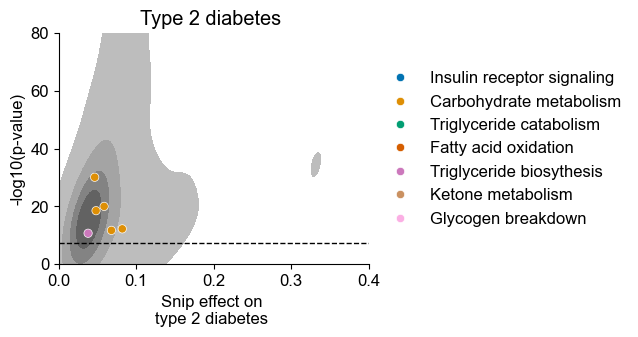

In [27]:
# Make plot for the main text 

#trait = 'Takes medication for Diabetes/sugar?'
#trait = 'Diabetes / "Sugar"'
trait = 'Type 2 diabetes (PheCode 250.2)'


glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()


selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['DISEASE/TRAIT'] == trait)
gwas_mapped_selected = gwas_mapped[selected_genes]

# Count the number of genes per study
num_genes_per_study = gwas_mapped_selected.groupby(['STUDY','PUBMEDID','DATE','FIRST AUTHOR','JOURNAL']).size()

# Select only a single study 
selected_study = num_genes_per_study.idxmax()


selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['DISEASE/TRAIT'] == trait) #& (gwas_mapped['STUDY'] == selected_study[0])
gwas_mapped_selected = gwas_mapped[selected_genes]

# Sort using the pathways preservin the order in the hue_order
gwas_mapped_selected['pathway'] = pd.Categorical(gwas_mapped_selected['pathway'], categories=hue_order, ordered=True)
gwas_mapped_selected = gwas_mapped_selected.sort_values('pathway')




f, ax = plt.subplots(figsize=(4, 3))
sns.kdeplot(gwas_selected, y='PVALUE_MLOG', x='OR or BETA', color='grey',ax=ax, fill=True, levels=5, thresh=0.05)
sns.scatterplot(data=gwas_mapped_selected, y='PVALUE_MLOG', x='OR or BETA', hue='pathway', hue_order=hue_order, palette='colorblind',
                 ax=ax, sizes=(0,300), size_norm=(0, 60),legend=True)




plt.ylim(0,80)
plt.xlim(0, 0.4)


# Add a horizontal line at the median of the effect size of this study
# gwas_selected = gwas[(gwas['PUBMEDID'] == selected_study[1]) & (gwas['DISEASE/TRAIT'] == trait)]
gwas_selected = gwas[ (gwas['DISEASE/TRAIT'] == trait)]


#median_effect_size = gwas_selected['OR or BETA'].median()
#plt.axvline(median_effect_size, color='black', linestyle='--', linewidth=1)

# 5e-8 line 
plt.axhline(-np.log10(5e-8), color='black', linestyle='--', linewidth=1)

ax.set_xlabel('Snip effect on \n' + trait.replace('(PheCode 250.2)', '') .lower())
ax.set_ylabel('-log10(p-value)')

# put the legend out of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
sns.despine()

# Add title from the fist authors and the year of the study
title = trait.replace('(PheCode 250.2)', '') #+'\n' + selected_study[3] + '. '+ str(selected_study[4])  +' (' + str(pd.to_datetime(selected_study[2]).year) + ')'
plt.title(title)

print(selected_study)

plt.savefig('./../output/gwas_v2_diabetes.svg', bbox_inches='tight')

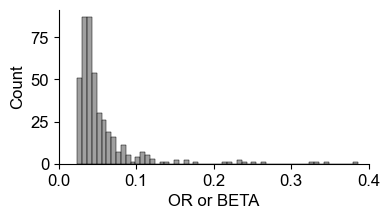

In [28]:
# Histo gram of all beta values in this study
f, ax = plt.subplots(figsize=(4, 2))
sns.histplot(gwas_selected['OR or BETA'], color='grey')
plt.xlim(0,0.4)
sns.despine()

In [29]:
gwas_selected.PUBMEDID.unique()


array([39024449])

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_2552/1908532860.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_mapped_selected['pathway'] = pd.Categorical(gwas_mapped_selected['pathway'], categories=hue_order, ordered=True)


('The trans-ancestral genomic architecture of glycemic traits.', 34059833, '2021-05-31', 'Chen J', 'Nat Genet')


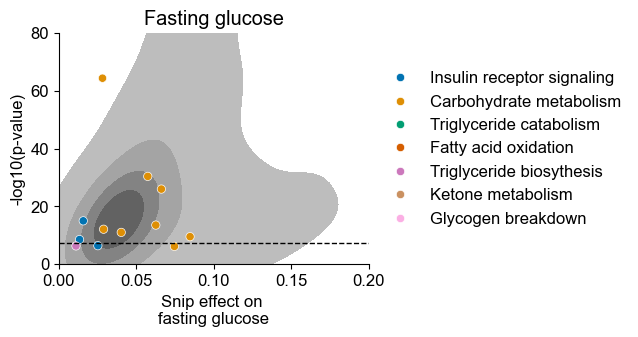

In [30]:
# Make plot for the main text 

trait = 'Fasting glucose'

glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()


selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['DISEASE/TRAIT'] == trait)
gwas_mapped_selected = gwas_mapped[selected_genes]

# Count the number of genes per study
num_genes_per_study = gwas_mapped_selected.groupby(['STUDY','PUBMEDID','DATE','FIRST AUTHOR','JOURNAL']).size()

# Select only a single study 
selected_study = num_genes_per_study.idxmax()


selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['DISEASE/TRAIT'] == trait) & (gwas_mapped['STUDY'] == selected_study[0])
gwas_mapped_selected = gwas_mapped[selected_genes]

# Sort using the pathways preservin the order in the hue_order
gwas_mapped_selected['pathway'] = pd.Categorical(gwas_mapped_selected['pathway'], categories=hue_order, ordered=True)
gwas_mapped_selected = gwas_mapped_selected.sort_values('pathway')



f, ax = plt.subplots(figsize=(4, 3))
sns.kdeplot(gwas_selected, y='PVALUE_MLOG', x='OR or BETA', color='grey',ax=ax, fill=True, levels=5, thresh=0.05)
sns.scatterplot(data=gwas_mapped_selected, y='PVALUE_MLOG', x='OR or BETA', hue='pathway', hue_order=hue_order, palette='colorblind',
                 ax=ax, sizes=(0,300), size_norm=(0, 60),legend=True)



plt.ylim(0,80)
plt.xlim(0, 0.2)


# Add a horizontal line at the median of the effect size of this study
gwas_selected = gwas[(gwas['PUBMEDID'] == selected_study[1]) & (gwas['DISEASE/TRAIT'] == trait)]
#gwas_selected = gwas[ (gwas['DISEASE/TRAIT'] == trait)]


#median_effect_size = gwas_selected['OR or BETA'].median()
#plt.axvline(median_effect_size, color='black', linestyle='--', linewidth=1)

# 5e-8 line 
plt.axhline(-np.log10(5e-8), color='black', linestyle='--', linewidth=1)

ax.set_xlabel('Snip effect on \n' + trait.replace('(PheCode 250.2)', '') .lower())
ax.set_ylabel('-log10(p-value)')

# put the legend out of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
sns.despine()

# Add title from the fist authors and the year of the study
title = trait.replace('(PheCode 250.2)', '') #+'\n' + selected_study[3] + '. '+ str(selected_study[4])  +' (' + str(pd.to_datetime(selected_study[2]).year) + ')'
plt.title(title)

print(selected_study)

plt.savefig('./../output/gwas_v2_fasting_glucose.svg', bbox_inches='tight')

In [31]:
gwas_selected.PUBMEDID.unique()


array([34059833])

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_2552/1196595528.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_mapped_selected['pathway'] = pd.Categorical(gwas_mapped_selected['pathway'], categories=hue_order, ordered=True)


('The trans-ancestral genomic architecture of glycemic traits.', 34059833, '2021-05-31', 'Chen J', 'Nat Genet')


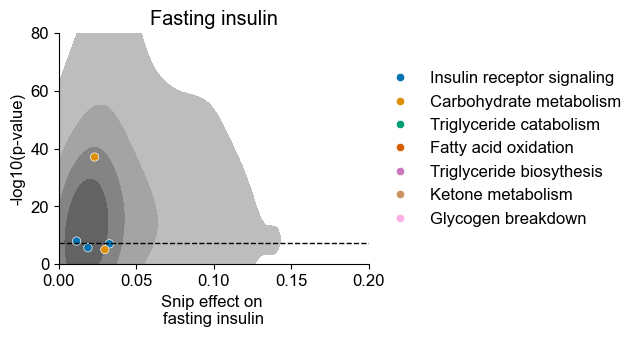

In [32]:
# Make plot for the main text 

trait = 'Fasting insulin'

glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()


selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['DISEASE/TRAIT'] == trait)
gwas_mapped_selected = gwas_mapped[selected_genes]

# Count the number of genes per study
num_genes_per_study = gwas_mapped_selected.groupby(['STUDY','PUBMEDID','DATE','FIRST AUTHOR','JOURNAL']).size()

# Select only a single study 
selected_study = num_genes_per_study.idxmax()


selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['DISEASE/TRAIT'] == trait) & (gwas_mapped['STUDY'] == selected_study[0])
gwas_mapped_selected = gwas_mapped[selected_genes]

# Sort using the pathways preservin the order in the hue_order
gwas_mapped_selected['pathway'] = pd.Categorical(gwas_mapped_selected['pathway'], categories=hue_order, ordered=True)
gwas_mapped_selected = gwas_mapped_selected.sort_values('pathway')



f, ax = plt.subplots(figsize=(4, 3))
sns.kdeplot(gwas_selected, y='PVALUE_MLOG', x='OR or BETA', color='grey',ax=ax, fill=True, levels=5, thresh=0.05)
sns.scatterplot(data=gwas_mapped_selected, y='PVALUE_MLOG', x='OR or BETA', hue='pathway', hue_order=hue_order, palette='colorblind',
                 ax=ax, sizes=(0,300), size_norm=(0, 60),legend=True)



plt.ylim(0,80)
plt.xlim(0, 0.2)


# Add a horizontal line at the median of the effect size of this study
gwas_selected = gwas[(gwas['PUBMEDID'] == selected_study[1]) & (gwas['DISEASE/TRAIT'] == trait)]
#gwas_selected = gwas[ (gwas['DISEASE/TRAIT'] == trait)]


#median_effect_size = gwas_selected['OR or BETA'].median()
#plt.axvline(median_effect_size, color='black', linestyle='--', linewidth=1)

# 5e-8 line 
plt.axhline(-np.log10(5e-8), color='black', linestyle='--', linewidth=1)

ax.set_xlabel('Snip effect on \n' + trait.replace('(PheCode 250.2)', '') .lower())
ax.set_ylabel('-log10(p-value)')

# put the legend out of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
sns.despine()

# Add title from the fist authors and the year of the study
title = trait.replace('(PheCode 250.2)', '') #+'\n' + selected_study[3] + '. '+ str(selected_study[4])  +' (' + str(pd.to_datetime(selected_study[2]).year) + ')'
plt.title(title)

print(selected_study)

plt.savefig('./../output/gwas_v2_fasting_insulin.svg', bbox_inches='tight')